<a href="https://colab.research.google.com/github/rohankavari/MachineLearning/blob/main/Bank_Note_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix , roc_curve , auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [11]:
col=['Variance',	'Skewness',	'Curtosis',	'Entropy'	,'Class']
df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt',header=None)
df.columns=col
df

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Variance  1372 non-null   float64
 1   Skewness  1372 non-null   float64
 2   Curtosis  1372 non-null   float64
 3   Entropy   1372 non-null   float64
 4   Class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [13]:
df.isna().sum()

Variance    0
Skewness    0
Curtosis    0
Entropy     0
Class       0
dtype: int64

In [14]:
classes=df['Class'].value_counts()
print("class distribution \n","B:",classes[0]/(classes[0]+classes[1]) *100,"%","\n M:",classes[1]/(classes[0]+classes[1]) *100,"%" )

class distribution 
 B: 55.539358600583085 % 
 M: 44.460641399416915 %


Class imbalance is present but not to a great extent.

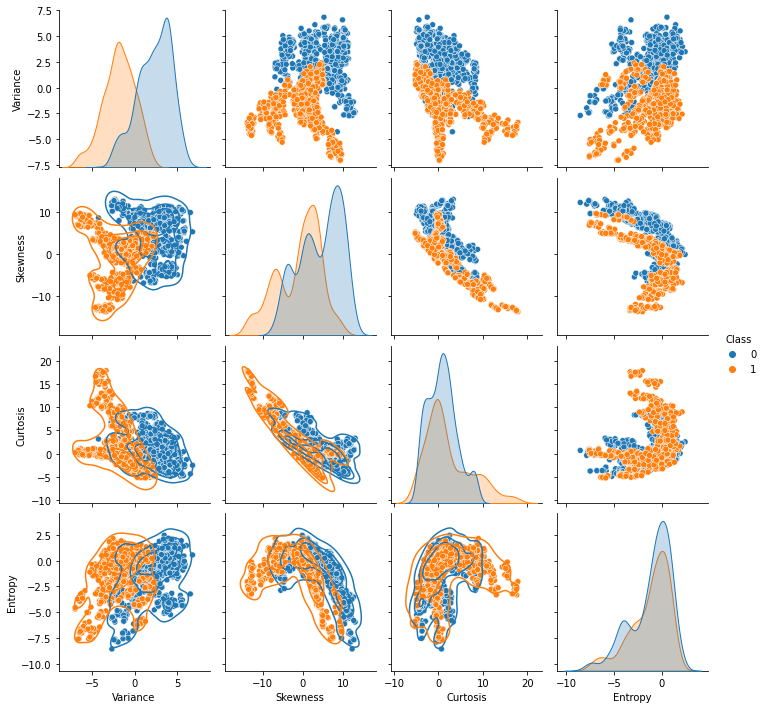

In [30]:
g=sns.pairplot(data=df, hue="Class")
g.map_lower(sns.kdeplot, levels=4, color=".2")

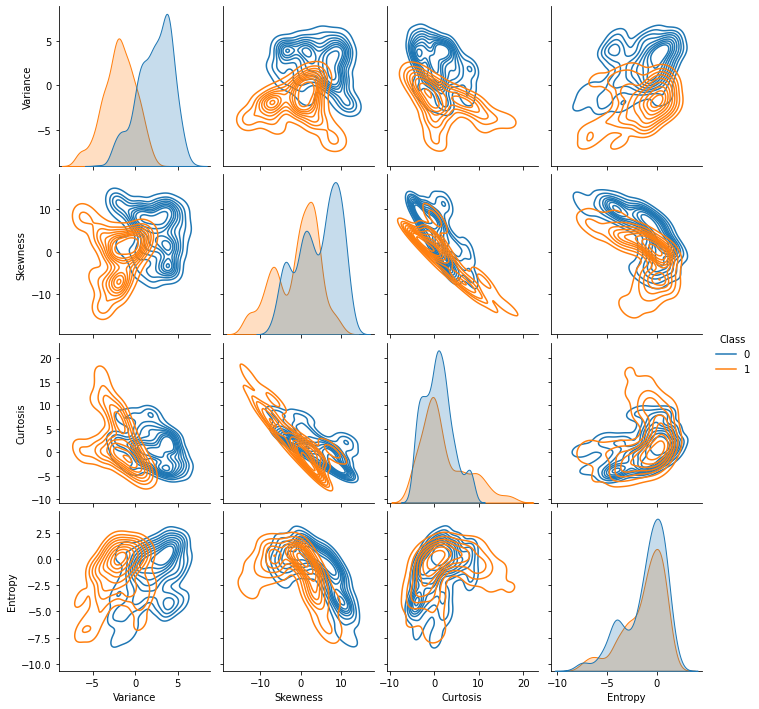

In [16]:
sns.pairplot(data=df, hue="Class",kind="kde")

Test-Train Split

In [32]:
y=df.iloc[:,4:5].values.ravel()
x=df.iloc[:,0:4]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)

Scaling the data as SVM is scale invariant.

Scaling

In [34]:
scaler = StandardScaler()
scaler.fit(x_train)
x_sca_train=scaler.transform(x_train)
x_sca_test=scaler.transform(x_test)

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
 plt.plot(fpr, tpr, linewidth=2, label=label)
 plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
 plt.legend()

# Model1

In [35]:
model1=LinearSVC(random_state=0,penalty='l1', loss='squared_hinge', dual=False)    
model1.fit(x_sca_train,y_train)
y_pred=model1.predict(x_sca_train)

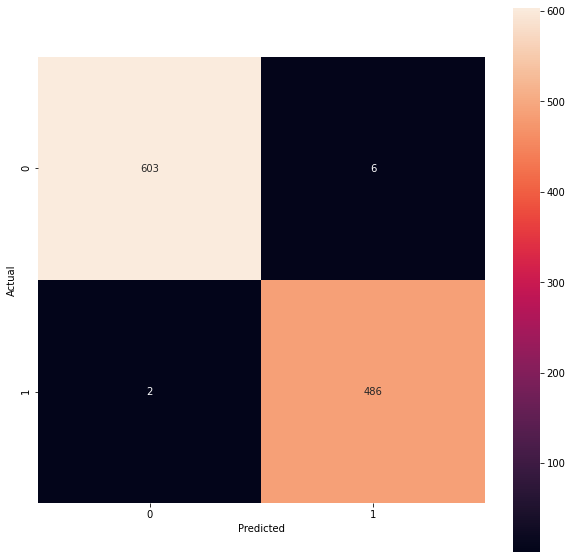

In [36]:
plt.figure(figsize=(10, 10))
a=sns.heatmap(confusion_matrix(y_train, y_pred),annot=True,fmt="d")
a.set(xlabel="Predicted", ylabel="Actual", aspect="equal");

In [37]:
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       609
           1       0.99      1.00      0.99       488

    accuracy                           0.99      1097
   macro avg       0.99      0.99      0.99      1097
weighted avg       0.99      0.99      0.99      1097



In [38]:
from sklearn.model_selection import cross_val_score
print("Cross Val Score:",cross_val_score(model1, x_sca_train, y_train, cv=3,scoring='f1'))
print("Cross Val Mean:",np.round(np.mean(cross_val_score(model1, x_sca_train, y_train, cv=3,scoring='f1')),10))
print("Cross Val Std:",np.round(np.std(cross_val_score(model1, x_sca_train, y_train, cv=3,scoring='f1')),10))

Cross Val Score: [0.99076923 0.98489426 0.99386503]
Cross Val Mean: 0.9898428404
Cross Val Std: 0.003720424


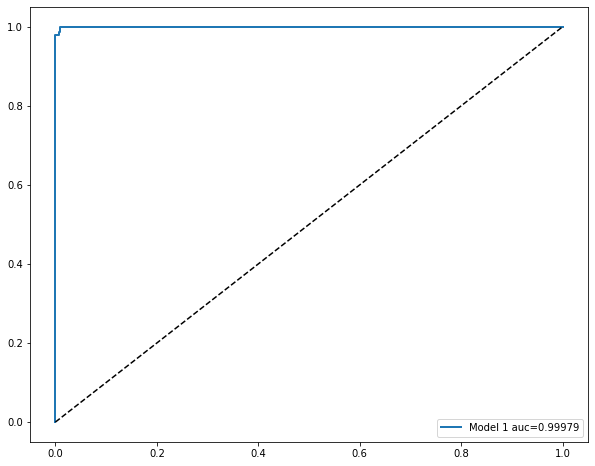

In [41]:
scores=model1.decision_function(x_sca_train)
fpr, tpr, thresholds = roc_curve(y_train, scores)
area=str(np.round(auc(fpr,tpr),5))
plt.figure(figsize = (10,8))
plot_roc_curve(fpr,tpr,"Model 1"+" auc="+area)

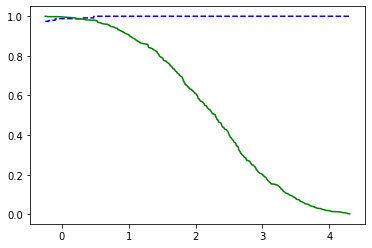

In [46]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

In [61]:
param_grid = {'C': [0.1, 1, 10, 100, 1000]
              } 
grid = GridSearchCV(model1, param_grid, refit = True, verbose = 7,scoring="f1", cv=10, n_jobs=-1)
grid.fit(x_sca_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l1',
                                 random_state=0, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='f1', verbose=7)

In [62]:
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.9908253713231623 with param: {'C': 1}


# Model 2

In [52]:
model2=LinearSVC(random_state=0,penalty='l1',class_weight="balanced", loss='squared_hinge', dual=False,max_iter=10000)    
model2.fit(x_sca_train,y_train)
y_pred=model2.predict(x_sca_train)

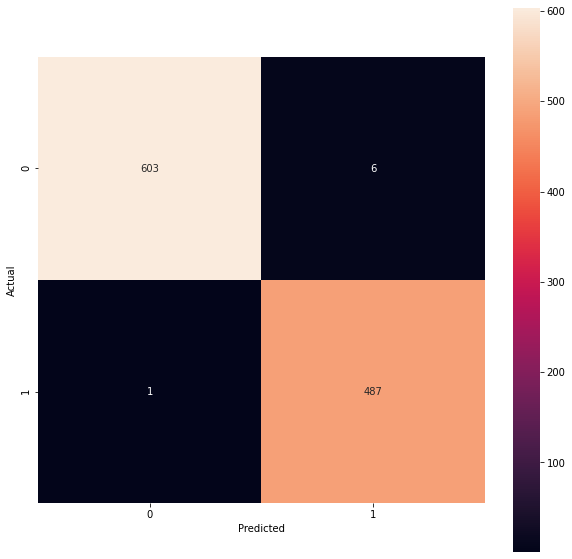

In [53]:
plt.figure(figsize=(10, 10))
a=sns.heatmap(confusion_matrix(y_train, y_pred),annot=True,fmt="d")
a.set(xlabel="Predicted", ylabel="Actual", aspect="equal");

In [55]:
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       609
           1       0.99      1.00      0.99       488

    accuracy                           0.99      1097
   macro avg       0.99      0.99      0.99      1097
weighted avg       0.99      0.99      0.99      1097



In [58]:
from sklearn.model_selection import cross_val_score
print("Cross Val Score:",cross_val_score(model2, x_sca_train, y_train, cv=3,scoring='f1'))
print("Cross Val Mean:",np.round(np.mean(cross_val_score(model1, x_sca_train, y_train, cv=3,scoring='f1')),10))
print("Cross Val Std:",np.round(np.std(cross_val_score(model1, x_sca_train, y_train, cv=3,scoring='f1')),10))

Cross Val Score: [0.99386503 0.98489426 0.99082569]
Cross Val Mean: 0.9898428404
Cross Val Std: 0.003720424


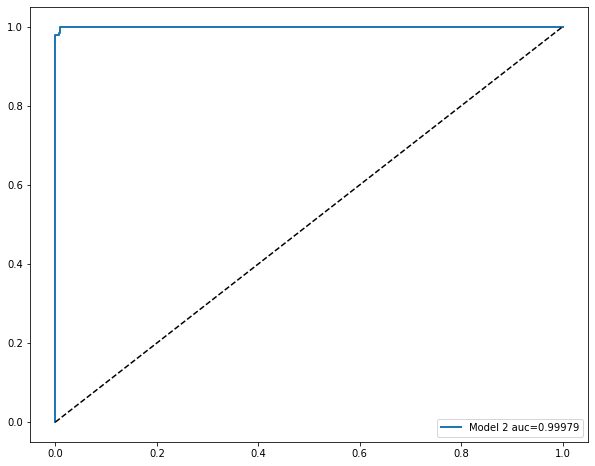

In [59]:
scores=model2.decision_function(x_sca_train)
fpr, tpr, thresholds = roc_curve(y_train, scores)
area=str(np.round(auc(fpr,tpr),5))
plt.figure(figsize = (10,8))
plot_roc_curve(fpr,tpr,"Model 2"+" auc="+area)

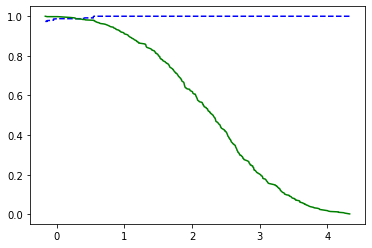

In [60]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

# Model Evaluation

In [63]:
pred_mod1=model1.predict(x_sca_test)
pred_mod2=model2.predict(x_sca_test)


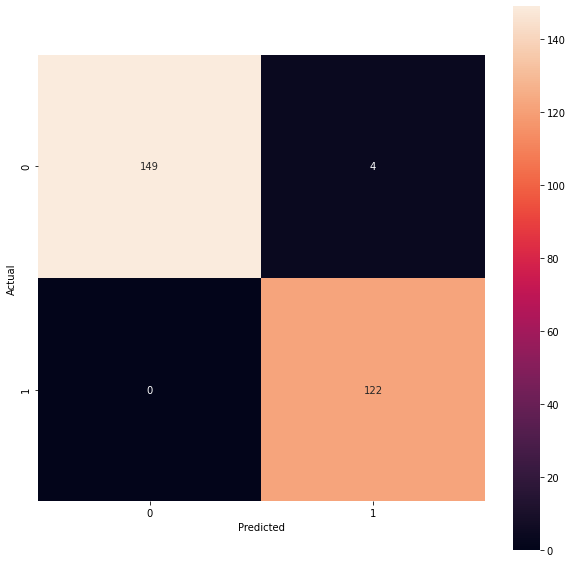

In [43]:
plt.figure(figsize=(10, 10))
a=sns.heatmap(confusion_matrix(y_test, pred_mod1),annot=True,fmt="d")
a.set(xlabel="Predicted", ylabel="Actual", aspect="equal");

In [44]:
print(metrics.classification_report(y_test, pred_mod1))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       153
           1       0.97      1.00      0.98       122

    accuracy                           0.99       275
   macro avg       0.98      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



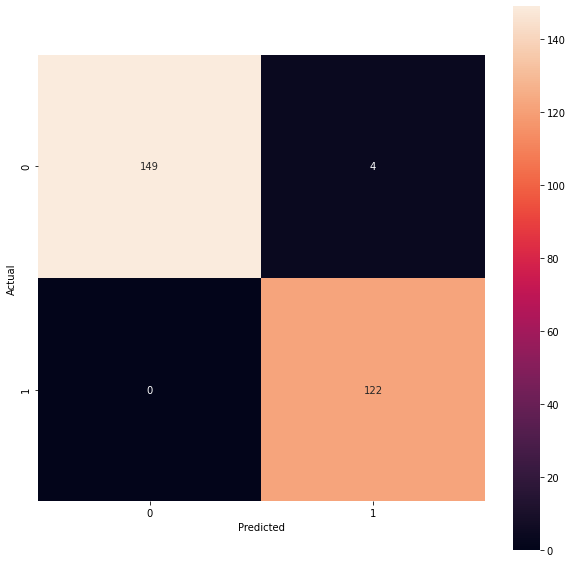

In [64]:
plt.figure(figsize=(10, 10))
a=sns.heatmap(confusion_matrix(y_test, pred_mod2),annot=True,fmt="d")
a.set(xlabel="Predicted", ylabel="Actual", aspect="equal");

In [65]:
print(metrics.classification_report(y_test, pred_mod2))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       153
           1       0.97      1.00      0.98       122

    accuracy                           0.99       275
   macro avg       0.98      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



Model 1 and 2 both are similar on test data performance wise. As Model 1 is a simpler model we will choose Model1.